In [1]:
# Import necessary PyTorch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import kornia.augmentation as A
import matplotlib.pyplot as plt
import numpy as np

import sys
import random

from utils.backdoor import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, IMAGENET_MIN, IMAGENET_MAX
from attack_models.autoencoders import ConditionalAutoencoder
from models.resnet_cifar import ResNet18


In [2]:
tgtmodel = ConditionalAutoencoder(n_classes=10, input_dim=32).to("cuda")
model = ResNet18().to("cuda")

# prefix = f"/hdd/home/ssd_data/Son/LRBA/saved_models/model_CIFAR10_01.21_16.01.49_cifar10"
prefix = "/hdd/home/ssd_data/Son/LRBA/saved_models/model_CIFAR10_01.21_16.12.04_cifar10"
path = prefix + "/model_last.pt.tar"
with open(path, "rb") as f:
    checkpoint = torch.load(f, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    tgtmodel.load_state_dict(checkpoint["tgt_state_dict"])

tgtoptimizer = torch.optim.Adam(tgtmodel.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [3]:
normalize = transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)

transform_train = transforms.Compose([transforms.ToTensor(), normalize,])
        
transform_test = transforms.Compose([transforms.ToTensor(), normalize])

train_dataset = torchvision.datasets.CIFAR10(
                        root=".data/",
                        train=True,
                        download=True,
                        transform=transform_train)

train_loader = DataLoader(train_dataset,
                        batch_size=64,
                        shuffle=True,
                        num_workers=0)
test_dataset = torchvision.datasets.CIFAR10(
                        root=".data/",
                        train=False,
                        download=True,
                        transform=transform_test)
test_loader = DataLoader(test_dataset,
                        batch_size=64,
                        shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

clip_image = lambda x: torch.clamp(x, IMAGENET_MIN, IMAGENET_MAX)
# target_transform = lambda x: torch.ones_like(x) * 8

def sample_negative_labels(label, n_classes):
    label_cpu = label.detach().cpu().numpy()
    neg_label = [np.random.choice([e for e in range(n_classes) if e != l], 1)[0] for l in label_cpu]
    neg_label = torch.tensor(np.array(neg_label))
    return neg_label.to('cuda')

def make_backdoor_batch(data, target, atkmodel, target_transform, multitarget=False):
    global clip_image
    if multitarget:
        atktarget = target_transform(target, n_classes=10)
        # noise = atkmodel(data, atktarget) * hlpr.params.eps
        noise = atkmodel(data, atktarget)
        # noise = torch.clamp(noise, -hlpr.params.eps, hlpr.params.eps)
        atkdata = clip_image(data + noise)
    else:
        # noise = atkmodel(data) * hlpr.params.eps
        noise = atkmodel(data)
        # noise = torch.clamp(noise, -hlpr.params.eps, hlpr.params.eps)
        atkdata = clip_image(data + noise)
        atktarget = target_transform(target)

    return atkdata, atktarget

target_transform = sample_negative_labels

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def imshow(img):
    plt.figure(figsize=(8, 8))
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

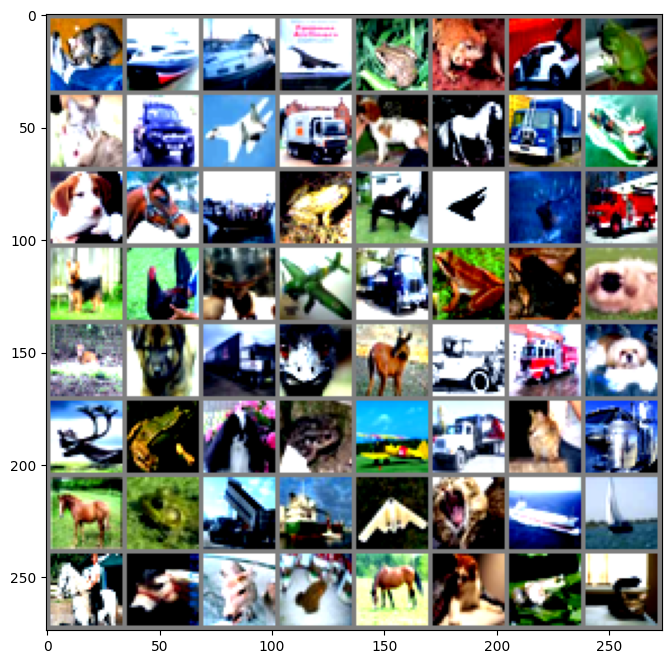

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3], device='cuda:0')
  cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog truck  ship plane   cat  ship  ship horse horse  deer  frog horse   cat  frog   cat


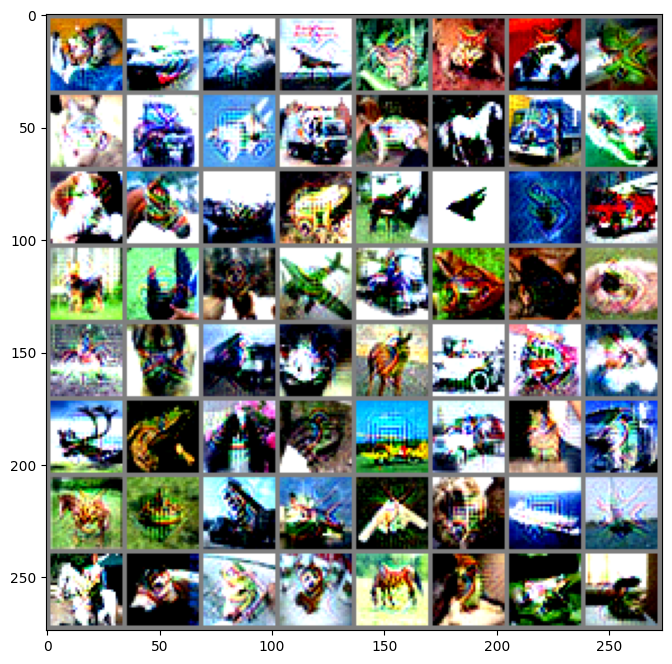

tensor([4, 6, 4, 7, 7, 3, 3, 0, 1, 4, 9, 5, 1, 2, 7, 7, 4, 6, 3, 9, 4, 2, 6, 1,
        7, 1, 5, 6, 7, 1, 1, 6, 7, 0, 2, 7, 2, 8, 6, 4, 9, 7, 8, 2, 9, 7, 7, 2,
        3, 8, 5, 0, 4, 9, 9, 0, 3, 5, 6, 5, 3, 2, 0, 4], device='cuda:0')
 deer  frog  deer horse horse   cat   cat plane   car  deer truck   dog   car  bird truck horse  deer  frog   cat truck  deer  bird  frog truck horse   car   dog  frog horse   car   car  frog horse plane  bird horse  bird  ship truck  deer truck horse  ship  bird truck horse horse  bird   cat  ship   dog plane  deer truck truck plane   cat   dog  frog   dog   cat  bird plane  deer


In [5]:
# Get a batch of data
data, target = next(iter(test_loader))
data, target = data.to('cuda'), target.to('cuda')

atkdata, atktarget = make_backdoor_batch(data, target, tgtmodel, target_transform, multitarget=True)
atkoutput = model(atkdata)
atkpred = atkoutput.max(1, keepdim=True)[1]  # get the index of the max log-probability

# Show images
imshow(torchvision.utils.make_grid(data))
print(target)
print(' '.join('%5s' % classes[target[j]] for j in range(64)))
imshow(torchvision.utils.make_grid(atkdata))
print(atktarget)
print(' '.join('%5s' % classes[atkpred[j]] for j in range(64)))

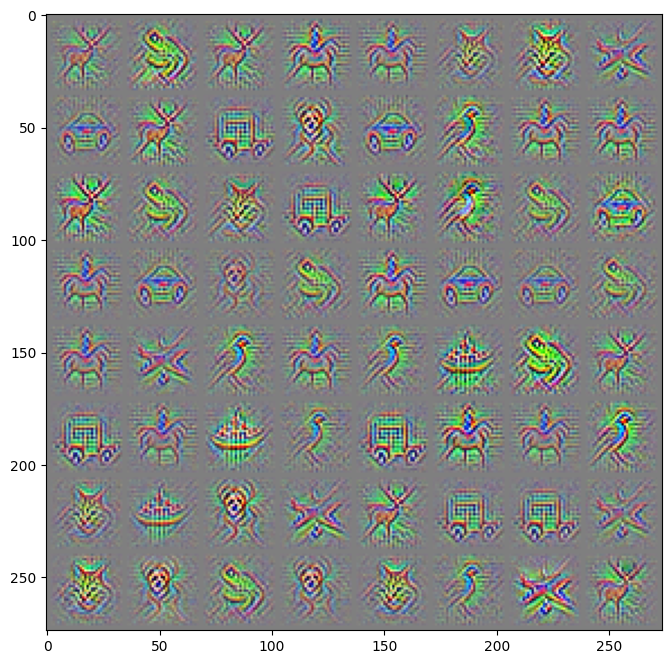

In [12]:
diff = atkdata - data
imshow(torchvision.utils.make_grid(diff))

In [91]:
list(enumerate(classes))

[(0, 'plane'),
 (1, 'car'),
 (2, 'bird'),
 (3, 'cat'),
 (4, 'deer'),
 (5, 'dog'),
 (6, 'frog'),
 (7, 'horse'),
 (8, 'ship'),
 (9, 'truck')]